In [3]:
import pandas

## Functions to get signal and single trial GLM

In [118]:
def get_signal(subject_id, run, mask):
    subject_id = '%02d' % int(subject_id)
    run = '%02d' % int(run)    
    run0 = int(run) - 1
    
    signal = np.loadtxt('/home/gdholla1/projects/bias/data/derivatives/extracted_signal/highpassed_motion/_mask_{mask}_subject_id_{subject_id}/_extracter_highpassed_motion{run0}/sub-{subject_id}_task-randomdotmotion_run-{run}_bold_unwarped_st_dtype_mcf_mask_gms_tempfilt_regfilt_maths_ts.txt'.format(**locals()))
    
    signal = (signal / signal.mean()) * 100
    signal -= signal.mean()
    
    return signal

def get_onsets(subject_id, run, design='single_trials_cue', shift=-3):

    df = pandas.read_pickle('/home/gdholla1/projects/bias/data/behavior/behavior.pandas')
    df = df[(df.subj_idx == subject_id) & (df.block == run)]

    df['onset_cue'] += shift
    df['onset_stim'] += shift
    
    
    if design == 'single_trials_cue':

        
        conditions = ['stim_easy', 'stim_hard']
        
        onsets = [df[df.difficulty == 'easy'].onset_stim.tolist(),
                  df[df.difficulty == 'hard'].onset_stim.tolist()]        

        

        conditions += ['trial %d' % trial for trial in df['trial_NR'].tolist()]
        
        onsets_cue = [[e] for e in df.onset_cue.tolist()]
        onsets +=  onsets_cue
        
    if design == 'single_trials_stim':

        
        conditions = ['payoff_cue', 'neutral_cue']
        
        onsets = [df[df.cue_validity != 'neutral'].onset_cue.tolist(),
                  df[df.cue_validity == 'neutral'].onset_cue.tolist()]        

        

        conditions += ['trial %d' % trial for trial in df['trial_NR'].tolist()]
        
        onsets_cue = [[e] for e in df.onset_stim.tolist()]
        onsets +=  onsets_cue
        
        
    
    return dict(zip(conditions, onsets))

# Get Single trials at cue

In [107]:
import itertools
import pyfir
from nipy.modalities.fmri import design_matrix, experimental_paradigm
import statsmodels.api as sm

level2_dict = []
adj_r = []
# pars = ['neutral_cue', 'left_cue', 'right_cue', 'neutral_easy_correct', 'valid_easy_correct', 'invalid_easy_correct', 'neutral_hard_correct', 'valid_hard_correct', 'invalid_hard_correct', 'easy_error', 'hard_error',]
# pars = 

mask = 'STh_L'

for subject_id in np.arange(1, 20):
    for run in [1,2,3]:

        try:
            onsets_dict = get_onsets(subject_id, run, 'single_trials_cue', shift=-3)
            pars = onsets_dict.keys()

            conditions = []
            onsets = []
            for key in onsets_dict.keys():
                conditions += [key] * len(onsets_dict[key])
                onsets += onsets_dict[key]

            paradigm =  experimental_paradigm.BlockParadigm(con_id=conditions, 
                                                            onset=onsets,
                                                            duration=[[1.]] * len(conditions))

            tr = 3.0
            frametimes = np.linspace(0, 387 * tr, 387)
            hrf_model = 'Canonical'

            X, names= design_matrix.dmtx_light(frametimes, paradigm, hrf_model=hrf_model, drift_model='polynomial', fir_delays=np.arange(11), drift_order=0)

            X /= X.max(0)
            X = pandas.DataFrame(X, columns=names)

            for i, mask in enumerate(['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C', 'STh_L', 'STh_R']):
                signal = get_signal(subject_id,  run, mask)
                r = sm.GLSAR(signal, X).iterative_fit()

                adj_r.append({'subject_id':subject_id, 'mask':mask, 'r2_adj':r.rsquared_adj, 'r2':r.rsquared, 'run':run})

                for par in pars:
                    level2_dict.append({'value':r.params[par],
                                        'par':par,
                                        'subject_id':subject_id,
                                        'mask':mask,
                                        'run':run})
        except Exception as e:
            print 'Error: %s/%s/%s' %  (subject_id, mask, e)

Error: 6/STh_R/all the input arrays must have same number of dimensions


In [108]:
behavior = pandas.read_pickle('/home/gdholla1/projects/bias/data/behavior/behavior.pandas')

In [109]:
df = pandas.DataFrame(level2_dict)


df['trial_NR'] = df.par.apply(lambda x: x.split()[-1] if x.split()[0] == 'trial' else np.nan)
df['mask'] = df['mask'].apply(lambda x: '%s_cue' % x)

df = df[~df.trial_NR.isnull()]
df['trial_NR'] = df.trial_NR.astype(int, inplace=True)

In [110]:
behavior['run'] = behavior.block
behavior['subject_id'] = behavior.subj_idx

In [111]:
df = behavior.merge(df.pivot_table(index=['subject_id', 'run', 'trial_NR'], columns=['mask'], values='value').reset_index(), on=['subject_id', 'run', 'trial_NR'])

# Get Single trials at stimulus

In [119]:
import itertools
import pyfir
from nipy.modalities.fmri import design_matrix, experimental_paradigm
import statsmodels.api as sm

level2_dict = []
adj_r = []
# pars = ['neutral_cue', 'left_cue', 'right_cue', 'neutral_easy_correct', 'valid_easy_correct', 'invalid_easy_correct', 'neutral_hard_correct', 'valid_hard_correct', 'invalid_hard_correct', 'easy_error', 'hard_error',]
# pars = 

mask = 'STh_L'

for subject_id in np.arange(1, 20):
    for run in [1,2,3]:

        try:
            onsets_dict = get_onsets(subject_id, run, 'single_trials_stim', shift=-3)
            pars = onsets_dict.keys()

            conditions = []
            onsets = []
            for key in onsets_dict.keys():
                conditions += [key] * len(onsets_dict[key])
                onsets += onsets_dict[key]

            paradigm =  experimental_paradigm.BlockParadigm(con_id=conditions, 
                                                            onset=onsets,
                                                            duration=[[1.]] * len(conditions))

            tr = 3.0
            frametimes = np.linspace(0, 387 * tr, 387)
            hrf_model = 'Canonical'

            X, names= design_matrix.dmtx_light(frametimes, paradigm, hrf_model=hrf_model, drift_model='polynomial', fir_delays=np.arange(11), drift_order=0)

            X /= X.max(0)
            X = pandas.DataFrame(X, columns=names)

            for i, mask in enumerate(['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C', 'STh_L', 'STh_R']):
                signal = get_signal(subject_id,  run, mask)
                r = sm.GLSAR(signal, X).iterative_fit()

                adj_r.append({'subject_id':subject_id, 'mask':mask, 'r2_adj':r.rsquared_adj, 'r2':r.rsquared, 'run':run})

                for par in pars:
                    level2_dict.append({'value':r.params[par],
                                        'par':par,
                                        'subject_id':subject_id,
                                        'mask':mask,
                                        'run':run})
        except Exception as e:
            print 'Error: %s/%s/%s' %  (subject_id, mask, e)

Error: 6/STh_R/all the input arrays must have same number of dimensions


In [120]:
df_stim = pandas.DataFrame(level2_dict)


df_stim['trial_NR'] = df_stim.par.apply(lambda x: x.split()[-1] if x.split()[0] == 'trial' else np.nan)
df_stim['mask'] = df_stim['mask'].apply(lambda x: '%s_stim' % x)

df_stim = df_stim[~df_stim.trial_NR.isnull()]
df_stim['trial_NR'] = df_stim.trial_NR.astype(int, inplace=True)

In [123]:
df = df.merge(df_stim.pivot_table(index=['subject_id', 'run', 'trial_NR'], columns=['mask'], values='value').reset_index(), on=['subject_id', 'run', 'trial_NR'])

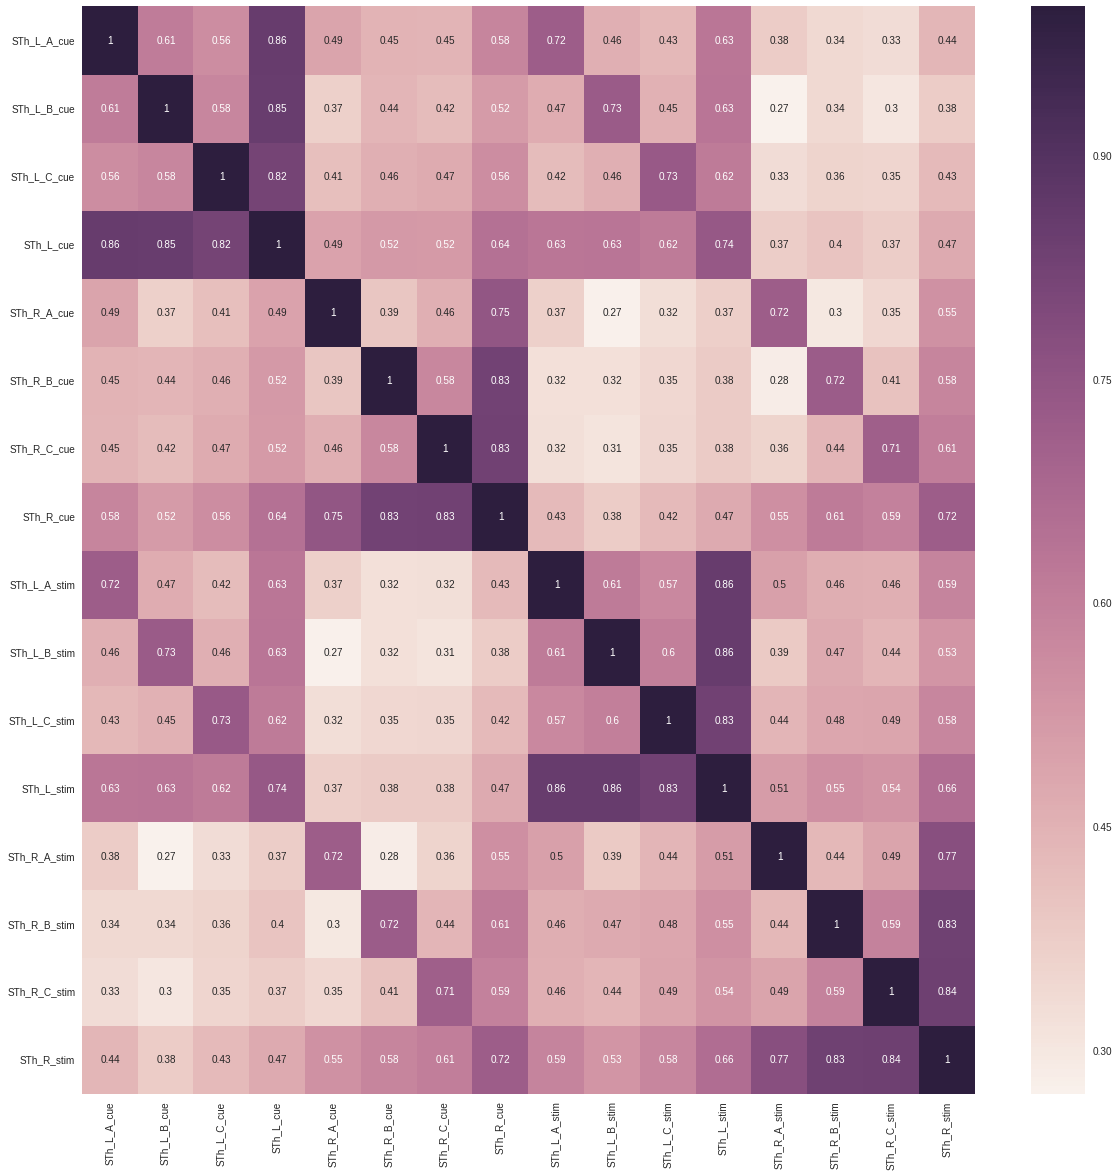

In [129]:
sns.heatmap(df.corr().iloc[-16:, -16:], annot=True)

plt.gcf().set_size_inches((20, 20))

In [131]:
df.to_pickle('/home/gdholla1/projects/bias/data/behavior/behavior_and_single_trial_estimates.pandas')

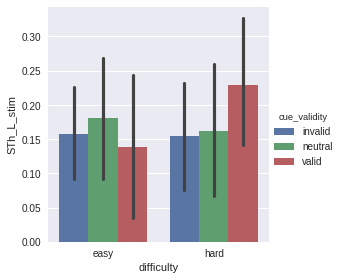

In [141]:
sns.factorplot('difficulty', 'STh_L_stim', 'cue_validity', data=df.groupby(['subject_id', 'difficulty', 'cue_validity'], as_index=False).mean(), units='subject_id', kind='bar')

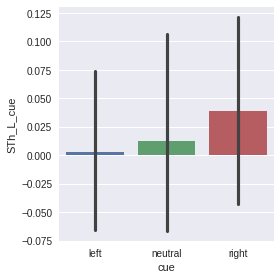

In [144]:
sns.factorplot('cue', 'STh_L_cue', data=df.groupby(['subject_id', 'cue'], as_index=False).mean(), units='subject_id', kind='bar')

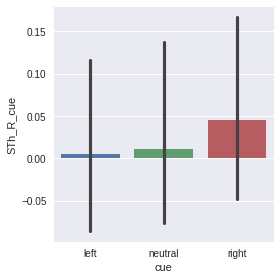

In [145]:
sns.factorplot('cue', 'STh_R_cue', data=df.groupby(['subject_id', 'cue'], as_index=False).mean(), units='subject_id', kind='bar')